In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras import regularizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax


## Loading Data

In [3]:
train_dir = (
    "../input/emotion-detection-fer/train"  # passing the path with training images
)
test_dir = "../input/emotion-detection-fer/test"  # passing the path with testing images


In [4]:
img_size = 48  # original size of the image


## Data Augmentation
* Image shift on x axis
* Image shift on y axis
* Horizontal_flip (mirror)
* Normalization
* Fraction of images reserved for validation (strictly between 0 and 1).

In [5]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1.0 / 255,
    validation_split=0.2,
)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)


### Applying data augmentation

In [6]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_size, img_size),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset="training",
)
validation_generator = validation_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_size, img_size),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation",
)


Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


## Creating the Model

In [7]:
model = tf.keras.models.Sequential()
model.add(
    Conv2D(
        32,
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
        input_shape=(img_size, img_size, 1),
    )
)
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5, 5), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation="softmax"))

model.compile(
    optimizer=Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"]
)


In [8]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

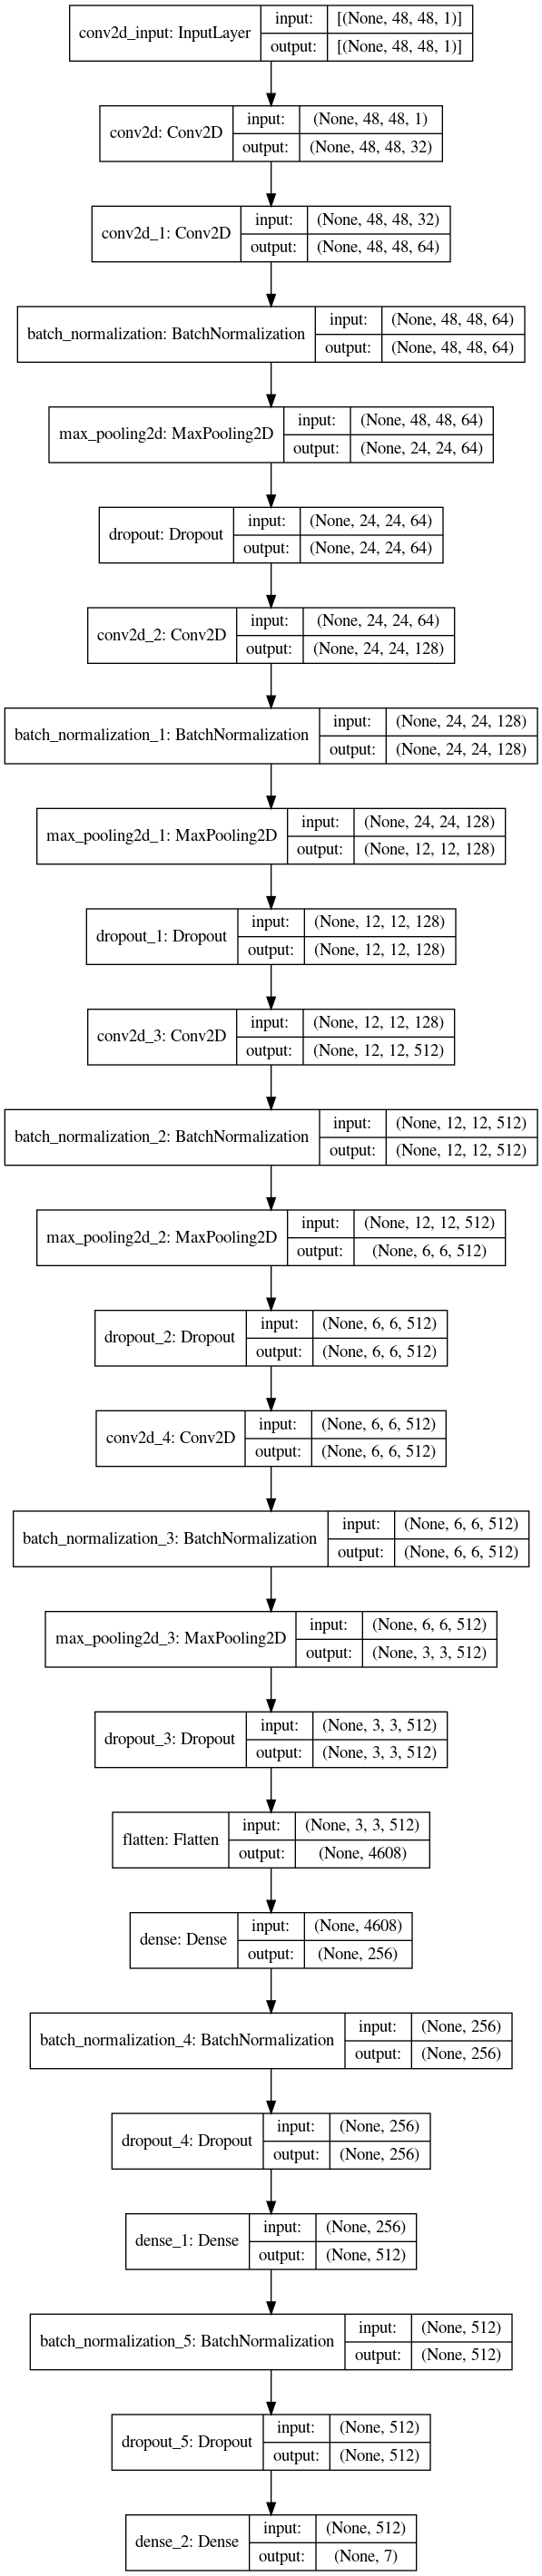

In [9]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="my_model.png", show_shapes=True)


In [10]:
history = model.fit(x=train_generator, epochs=60, validation_data=validation_generator)


Epoch 1/60
359/359 [==============================] - 114s 306ms/step - loss: 2.5299 - accuracy: 0.1833 - val_loss: 2.9243 - val_accuracy: 0.1718
Epoch 2/60
359/359 [==============================] - 29s 80ms/step - loss: 2.1592 - accuracy: 0.2206 - val_loss: 1.9652 - val_accuracy: 0.2549
Epoch 3/60
359/359 [==============================] - 28s 79ms/step - loss: 2.0283 - accuracy: 0.2438 - val_loss: 1.7964 - val_accuracy: 0.3010
Epoch 4/60
359/359 [==============================] - 28s 79ms/step - loss: 1.9607 - accuracy: 0.2694 - val_loss: 1.7182 - val_accuracy: 0.3303
Epoch 5/60
359/359 [==============================] - 37s 103ms/step - loss: 1.8778 - accuracy: 0.2978 - val_loss: 1.6009 - val_accuracy: 0.3750
Epoch 6/60
359/359 [==============================] - 45s 125ms/step - loss: 1.7935 - accuracy: 0.3257 - val_loss: 1.6087 - val_accuracy: 0.3834
Epoch 7/60
359/359 [==============================] - 50s 138ms/step - loss: 1.7285 - accuracy: 0.3500 - val_loss: 2.8911 - val_accu

## Plotting 

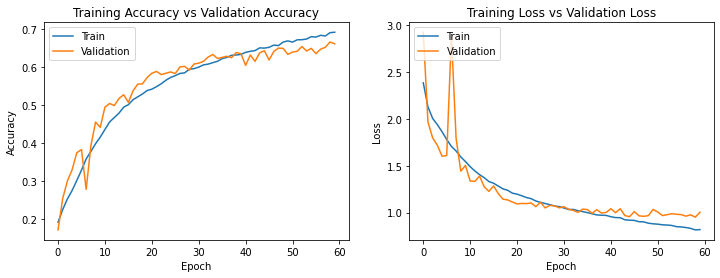

In [11]:
fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
fig.set_size_inches(12, 4)

ax[0].plot(history.history["accuracy"])
ax[0].plot(history.history["val_accuracy"])
ax[0].set_title("Training Accuracy vs Validation Accuracy")
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].legend(["Train", "Validation"], loc="upper left")

ax[1].plot(history.history["loss"])
ax[1].plot(history.history["val_loss"])
ax[1].set_title("Training Loss vs Validation Loss")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].legend(["Train", "Validation"], loc="upper left")

plt.show()


## Saving the model

In [12]:
model.save("model_optimal.h5")


In [14]:
label_dict = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise",
}


In [17]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(validation_generator)
print(
    "final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(
        train_acc * 100, test_acc * 100
    )
)


23/23 [==============================] - 1s 57ms/step - loss: 1.0032 - accuracy: 0.6620
final train accuracy = 73.96 , validation accuracy = 66.20


In [18]:
model.save_weights("model_weights.h5")


In [25]:
probabilities = model.predict(validation_generator)


In [29]:
y_true = validation_generator.classes


In [42]:
y_true.shape


(1432,)

In [44]:
np.argmax(probabilities, axis=1).shape


(1432,)

## Confusion matrix

Confusion matrix, without normalization


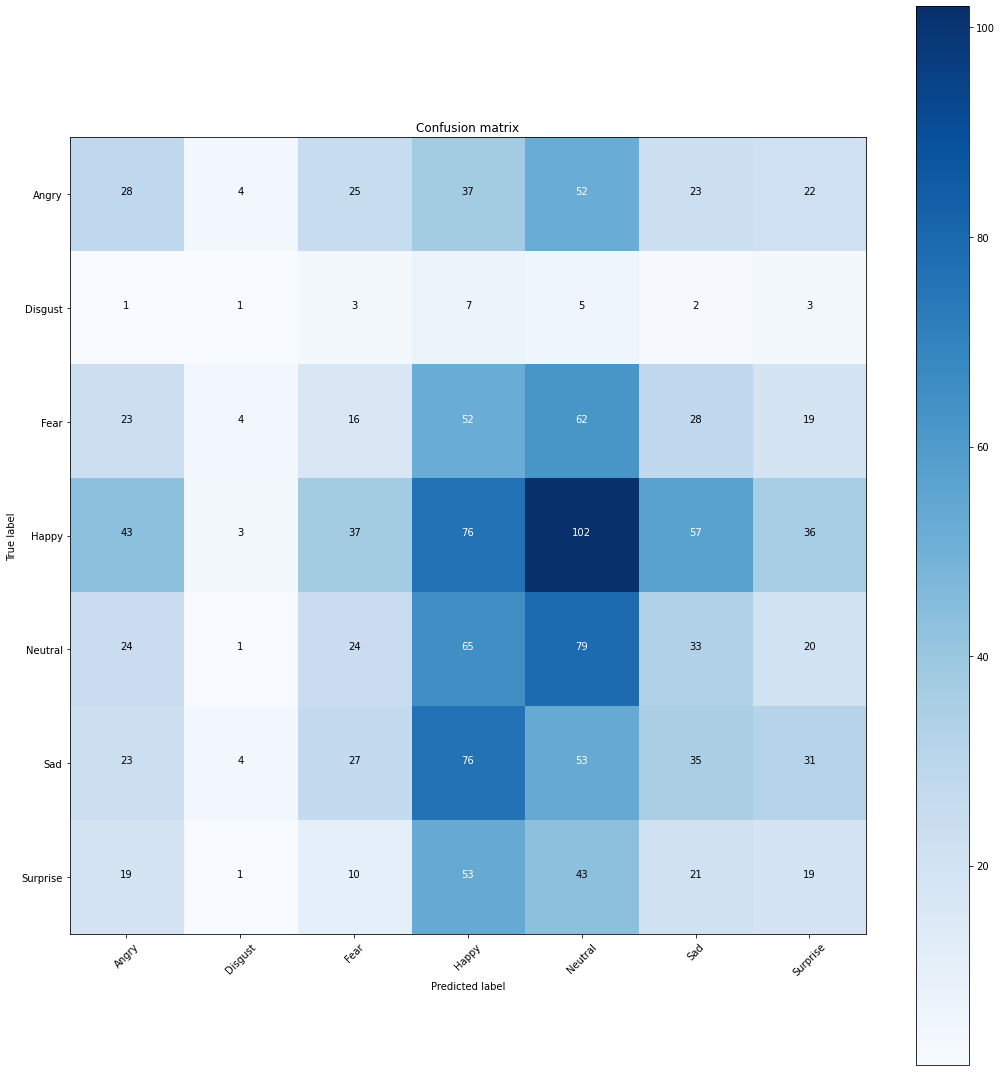

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


# plt.show()


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    # save plot to file
    plt.savefig("confusion_matrix.png")


cnf_matrix = confusion_matrix(y_true, np.argmax(probabilities, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(cnf_matrix, classes=label_dict.values(), title="Confusion matrix")


In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_true, np.argmax(probabilities, axis=1)))


              precision    recall  f1-score   support

           0       0.17      0.15      0.16       191
           1       0.06      0.05      0.05        22
           2       0.11      0.08      0.09       204
           3       0.21      0.21      0.21       354
           4       0.20      0.32      0.25       246
           5       0.18      0.14      0.16       249
           6       0.13      0.11      0.12       166

    accuracy                           0.18      1432
   macro avg       0.15      0.15      0.15      1432
weighted avg       0.17      0.18      0.17      1432

